In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Read the data

Function for reading ECG signals from a file

In [2]:
def read_X(filename):
    X = list()
    with open(filename) as f:
        while True:
            line = f.readline()
            if not line:
                break
            amplitudes = [int(x) for x in line.strip().split(',')]
            intervals = [int(x) for x in f.readline().strip().split(',')]
            
            f.readline() # skip an empty line
            X.append((amplitudes, intervals))
    return X

Read ECG signals of the train and test set

In [3]:
X_train_ecg = read_X('X.train.csv')
X_test_ecg = read_X('X.test.csv')
print(len(X_train_ecg), len(X_test_ecg))

900 903


Read labels of the train set

In [4]:
y_train = list()
for line in open('y.train.csv'):
    y_train.append(int(line))
print(len(y_train))

900


# Create trigram representation

Function for discretization of the ECG signals into 6 values (6 letters)

In [6]:
def discretize(X):
    discrete = list()
    for amps, ints in X:
        amps = array(amps).astype(float)
        ints = array(ints).astype(float)
        alphas = arctan(amps / ints)

        amps = diff(amps)
        ints = diff(ints)
        alphas = diff(alphas)

        s = list()
        for ind, r, t, a in zip(range(600), amps, ints, alphas):
            c = 'x'
            if r > 0 and t > 0 and a > 0:
                c = 'a'
            if r <= 0 and t <= 0 and a > 0:
                c = 'b'
            if r > 0 and t <= 0 and a > 0:
                c = 'c'
            if r <= 0 and t > 0 and a <= 0:
                c = 'd'
            if r > 0 and t > 0 and a <= 0:
                c = 'e'
            if r <= 0 and t <= 0 and a <= 0:
                c = 'f'
            if c == 'x':
                print('Very strange!!!', ind, r, t, a)
            s.append(c)

        discrete.append(s)
    return discrete

Apply it to our data. RuntimeWarning is fine, because of zeros in intervals. 

In [7]:
X_train_discrete = discretize(X_train_ecg)
X_test_discrete = discretize(X_test_ecg)
print(len(X_train_discrete), len(X_test_discrete))

900 903


/home/alexey/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


Function for counting trigrams and saving it in the numpy array format

In [8]:
from collections import defaultdict
from itertools import product

def vectorize(discrete):
    vectorized = list()
    for element in discrete:
        current = defaultdict(int)
        for j in range(597):
            current[tuple(element[j:j+3])] += 1

        vect = list()
        for a, b, c in product('abcdef', 'abcdef', 'abcdef'):
            vect.append(current[(a, b, c)])
        vectorized.append(vect)
    return array(vectorized).astype(float)

Create final train and test matrices

In [10]:
X_train = vectorize(X_train_discrete)
X_test = vectorize(X_test_discrete)
print(X_train.shape, X_test.shape)

(900, 216) (903, 216)


# Machine learning

Use 5-fold crossvalidation for finding optimal K in KNN

In [11]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score

params = {'n_neighbors': arange(1, 200, 5)}
grid_searcher = GridSearchCV(KNN(),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

0.956093044733
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=36, p=2, weights='uniform')


Function for plotting the results

In [12]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    plot(params[param_name], means)
    fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('AUC')

Plot results

/home/alexey/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


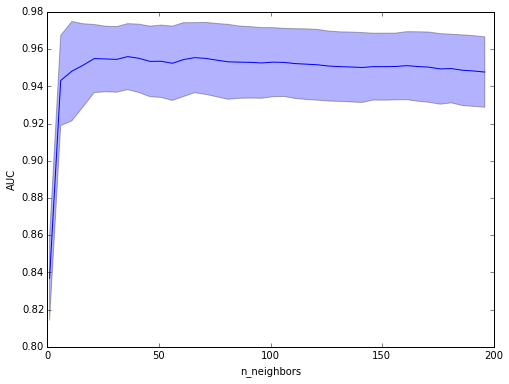

In [13]:
plot_quality(grid_searcher, 'n_neighbors')

Save the results in the proper format

In [16]:
clf = grid_searcher.best_estimator_.fit(X_train, y_train)
results = clf.predict_proba(X_test)[:, 1]
f = open('y.test.csv', 'w')
print('Id,Prediction', file=f)
for i, result in enumerate(results):
    print(str(i+1) + ',' + str(result), file=f)
f.close()

# My code

Отмасштабируем данные

In [83]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train, with_mean = True, with_std=True, axis=0)
X_test_scaled = scale(X_test, with_mean = True, with_std=True, axis=0)

Посмотрим, как выглядят наши данные в проекции на разные плоскости из двух признаков

In [104]:
c = ["blue", "red"]
colors = [c[y_train[i]] for i in range(len(y_train))]

/home/alexey/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


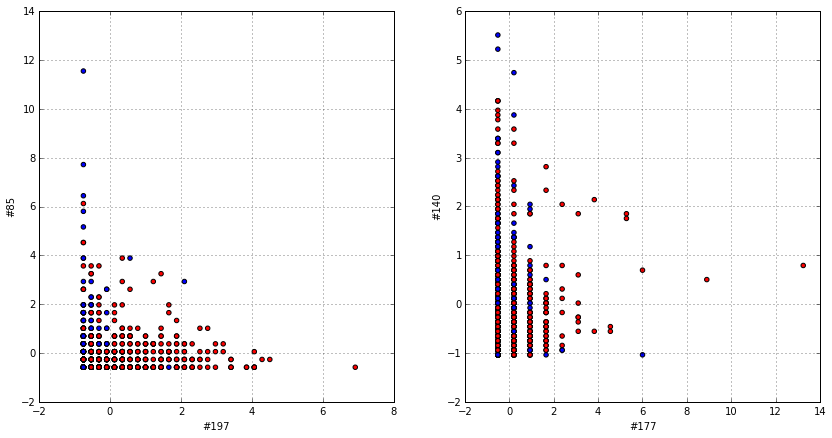

In [187]:
figure(figsize=(14,7))
U = X_train_scaled

for i in range(2):
    first = np.random.randint(6 * 6 * 6)
    second = np.random.randint(6 * 6 * 6)    
    subplot(1, 2, 1 + i), scatter(U[:, first], U[:, second], c=colors), \
        grid(True), xlabel('#{}'.format(first)), ylabel('#{}'.format(second))

Иногда проскакивают такие пары признаков, в которых хорошо отделяются синие от красных. 

Можно посмотреть, насколько хорошо можно классифицировать по одному признаку. Эту хорошесть будем использовать как вес в метрике.

In [276]:
def index_weight(index):
    params = {'n_neighbors': arange(1, 60, 5)}
    grid_searcher = GridSearchCV(KNN(weights='uniform', metric='minkowski', p=1),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
    grid_searcher.fit(X_train_scaled[:, [index]], y_train)
    return grid_searcher.best_score_

learned_weights = np.array([index_weight(index) for index in range(6*6*6)])

print(learned_weights)

[ 0.69391854  0.61903088  0.74847746  0.735872    0.57884396  0.74793331
  0.56602775  0.64323437  0.51354378  0.67421866  0.55941901  0.6716773
  0.73162657  0.52802281  0.74943718  0.84327982  0.56194893  0.86995215
  0.7784237   0.67001899  0.73528208  0.61394825  0.50896563  0.6326441
  0.54829465  0.69573473  0.55968733  0.68047702  0.64950255  0.61392139
  0.81271517  0.51991813  0.75783938  0.8709474   0.66074852  0.77899669
  0.56165267  0.55077278  0.52003639  0.71386044  0.82435843  0.57406216
  0.75135049  0.72459903  0.76692467  0.68210097  0.78287112  0.63192675
  0.68334622  0.67515165  0.61129063  0.7304174   0.86617062  0.52019713
  0.59053708  0.62005497  0.5288269   0.48982284  0.64662856  0.58394711
  0.60427998  0.6654391   0.6203913   0.80381884  0.80693025  0.64076038
  0.60091025  0.63661532  0.51493693  0.53782672  0.61544596  0.58389837
  0.66356537  0.5529239   0.73256031  0.57282092  0.63276178  0.80460176
  0.51830017  0.69863932  0.6152046   0.50888406  0.6

А сейчас мы попробуем отыскать такие пары признаков, в которых можно хорошо классифицировать. То есть клеткой выше мы пытаемся классифицировать используя 1 признак, а здесь будем с помощью двух.

In [287]:
def pair_weight(first, second):
    params = {'n_neighbors': arange(1, 60, 5)}
    grid_searcher = GridSearchCV(KNN(weights='uniform', metric='minkowski', p=1),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
    grid_searcher.fit(X_train_scaled[:, [first, second]], y_train)
    return grid_searcher.best_score_

pair_weights = np.array([[0 if second >= first else pair_weight(first, second)\
                          for second in range(6*6*6)]\
                          for first in range(6*6*6)])

In [294]:
f = open('pair_weights.csv', 'w')

for i in range(6*6*6):
    print(*pair_weights[i, :], sep=', ', file=f)
    

In [301]:
ordered_arg = np.argsort(-pair_weights, axis=None)

ordered_arg = np.array([[number // (6*6*6), number % (6*6*6)] for number in ordered_arg])

print(ordered_arg.shape)
print(ordered_arg)
print(pair_weights[ordered_arg[:10, 0], ordered_arg[:10, 1]])

(46656, 2)
[[163 102]
 [182 125]
 [200 102]
 ..., 
 [ 71 116]
 [ 71 118]
 [215 215]]
[ 0.94049177  0.93016604  0.92922698  0.92729687  0.92690244  0.92657915
  0.92554773  0.92525031  0.92516381  0.92415575]


In [390]:
pair_weights[ordered_arg[20000, 0], ordered_arg[20000, 1]]

0.62651693335471115

Уберём из рассмотрения плохие признаки, используя порог на хорошесть. Веса оставшихся признаков немного растянем.

In [351]:
number_of_pairs = 100
good_features = unique(ordered_arg[:number_of_pairs].reshape(number_of_pairs * 2))
print(len(good_features))
metric_weights = np.zeros(6*6*6)
metric_weights[good_features] = 1

42


In [401]:
def make_metric_weights_from_pair(treshold, power):
    metric_weights = np.zeros(6*6*6)

    for i in range(6*6*6):
        for j in range(i):
            addition = pow(max(pair_weights[i, j] - treshold, 0), power)
            metric_weights[i] += addition 
            metric_weights[j] += addition
    
    return metric_weights

In [460]:
pair_treshold = 0.75
pair_power = 0.5
metric_weights = make_metric_weights_from_pair(pair_treshold, pair_power)

print(min(metric_weights))
print(max(metric_weights))
print(mean(metric_weights))
#metric_weights -= mean(metric_weights)
#metric_weights[metric_weights < 0] = 0

10.1307749694
81.2181197103
27.6507529145


In [422]:
def make_metric_weights(treshold, power):
    
    metric_weights = learned_weights - treshold
    metric_weights[learned_weights < treshold] = 0
    metric_weights = pow(metric_weights, power)
    
    return metric_weights

In [463]:
treshold = 0.6
power = 1
pair_treshold = 0.75
pair_power = 1

metric_weights = make_metric_weights_from_pair(pair_treshold, pair_power) + 300 * make_metric_weights(treshold, power)

print(min(metric_weights))
print(max(metric_weights))
print(mean(metric_weights))

2.61166130939
116.281022308
31.5152791545


In [470]:
params = {'n_neighbors': arange(10, 100, 5),\
          #'metric_params': 
          #    [{'w': make_metric_weights(treshold, power)} \
          #     for treshold, power in product(arange(0.5, 0.88, 0.01), [1, 2])]\
          }
grid_searcher = GridSearchCV(KNN(weights='distance', metric='wminkowski', p=1, w=metric_weights),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X_train_scaled, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

0.966012509219
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='wminkowski',
           metric_params={'w': array([ 33.77909,   9.39609, ...,   3.20221,  32.31026])},
           n_neighbors=20, p=1, weights='distance')


/home/alexey/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


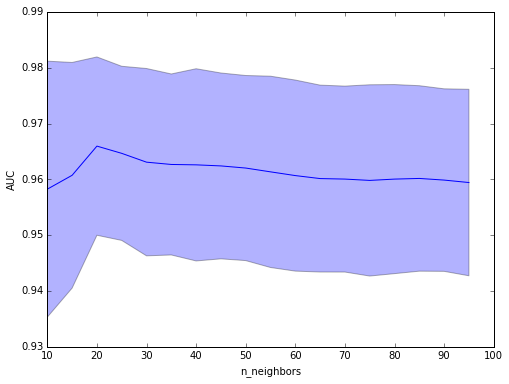

In [471]:
plot_quality(grid_searcher, 'n_neighbors')

In [472]:
clf = grid_searcher.best_estimator_.fit(X_train_scaled, y_train)

results = clf.predict_proba(X_test_scaled)[:, 1]
f = open('y.test.csv', 'w')
print('Id,Prediction', file=f)
for i, result in enumerate(results):
    print(str(i+1) + ',' + str(result), file=f)
f.close()